# Pruning Neural Networks

In [115]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Sequential

tf.enable_eager_execution()
tf.set_random_seed(42)

%matplotlib inline

## Data Loader

In [109]:
class DataLoader():
    BatchSize = 32
    
    def __init__(self):
        return
    
    def load_data(self):
        
        mnist = tf.keras.datasets.mnist
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        
        # Normalise the image pixel values
        x_train = x_train/255
        x_test = x_test/255
        
        return x_train, y_train, x_test, y_test

## Neural Network Pruner

In [127]:
class NeuralNetworkPruner():
    InputShape = 28
    BatchSize = 64
    NumNeuronsFirstHiddenLayer = 1000
    NumNeuronsSecondHiddenLayer = 1000
    NumNeuronsThirdHiddenLayer = 500
    NumNeuronsFourthHiddenLayer = 200
    NumNeuronsFinalLayer = 10
    UnitPruningString = 'unit'
    WeightPruningString = 'weight'
    
    def __init__(self, 
                 num_epochs = 5, 
                 optimizer = 'adam', 
                 loss = 'sparse_categorical_crossentropy',
                 verbose = False):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = ['accuracy']
        self.verbose = verbose
        
        self.prune_func = {
            self.UnitPruningString: self._unit_pruning,
            self.WeightPruningString: self._weight_pruning
        }
        
        # Initialise the model
        self._initialise_model()
    
    def _initialise_model(self):
        '''
        Initialise the model architecture and compile the model.
        '''
        
        # Define the model architecture
        self.model = Sequential([
            Flatten(input_shape = (self.InputShape, self.InputShape)),
            Dense(self.NumNeuronsFirstHiddenLayer, activation = tf.nn.relu, use_bias = False),
            Dense(self.NumNeuronsSecondHiddenLayer, activation = tf.nn.relu, use_bias = False),
            Dense(self.NumNeuronsThirdHiddenLayer, activation = tf.nn.relu, use_bias = False),
            Dense(self.NumNeuronsFourthHiddenLayer, activation = tf.nn.relu, use_bias = False),
            Dense(self.NumNeuronsFinalLayer, activation = tf.nn.softmax, use_bias = False)
        ])
        
        # Compile the model
        self.model.compile(
            optimizer = self.optimizer,
            loss = self.loss,
            metrics = self.metrics
        )
        
    def fit(self, X, y):
        '''
        Fit model to the training data.
        '''
        
        self.model.fit(x = X, 
                       y = y, 
                       epochs = self.num_epochs,
                       batch_size = self.BatchSize, 
                       verbose = self.verbose)
      
    
    def fit_prune(self, X, y, prune_strategy = 'weight', prune_sparsity = 10):
        '''
        Fit the model after pruning away some percentage of the weights.
        '''
        
        # Fit the model without any pruning
        self.fit(X, y)
        
        # Prune the fitted model's weights
        self.prune_func[prune_strategy](prune_sparsity)
        
    def _weight_pruning(self, prune_sparsity):
        '''
        Pruning using the weight strategy.
        '''
        
        model_weights = self.model.trainable_weights
        num_layers = len(model_weights)
        
        # Cycle through the weight matrices of each layer and prune those weights
        new_weights = []
        for index, weight_matrix in enumerate(model_weights):
            weights = weight_matrix.numpy()
            
            # If last layer, then dont prune it
            if index == num_layers - 1:
                new_weights.append(weights)
                continue
            
            # Get the critical value at the pruning sparsity
            critical_value = np.percentile(np.abs(weights), prune_sparsity)
            
            # Get indices of all weights which are below the critical value
            mask_indices = np.abs(weights) < critical_value
            
            # Remove them (or make them 0)
            weights[mask_indices] = 0
            new_weights.append(weights)
            
        # Update weights of current model
        self.model.set_weights(new_weights)
    
    def _unit_pruning(self, prune_sparsity):
        '''
        Pruning using the unit/neuron strategy.
        '''
        
        model_weights = self.model.trainable_weights
        num_layers = len(model_weights)
        
        new_weights = []
        for index, weight_matrix in enumerate(model_weights):
            weights = weight_matrix.numpy()
            
            # If last layer, then dont prune it
            if index == num_layers - 1:
                new_weights.append(weights)
                continue
            
            # Calculating the l2 norm of the neurons - the entire columns
            l2_norm_values = np.sqrt(np.sum(weights**2, axis = 0))
            critical_value = np.percentile(l2_norm_values, prune_sparsity)
            mask_indices = l2_norm_values < critical_value
            
            # Setting entire neuron columns to 0 - equivalent to removing the neurons
            weights[:, mask_indices] = 0
            new_weights.append(weights)
        
        # Update weights of current model
        self.model.set_weights(new_weights)
    
    def predict_proba(self, X):
        '''
        Return the raw probabilities for each of the classes.
        '''
        
        predicted_probs = self.model.predict(X)
        return predicted_probs
    
    def predict(self, X):
        '''
        Return the predicted classes for each data point.
        '''
        
        probs = self.predict_proba(X)
        pred = np.argmax(probs, axis = 1)
        return pred
    
    def get_eval_metric(self, y, y_pred):
        '''
        Return the evaluation metric for a set of true labels and predictions.
        '''
        
        return np.mean(y == y_pred)*100
    
    def get_loss(self, X, y):
        '''
        Return the loss function value for a data and true labels.
        '''
        
        loss, accuracy = self.model.evaluate(X, y, verbose = 0)
        return loss, accuracy

## Lets Get Started!

In [111]:
data_loader = DataLoader()
x_train, y_train, x_test, y_test = data_loader.load_data()

### 1. Weight Pruning

In [128]:
sparsities = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
weighted_pruning_train_loss = []
weighted_pruning_train_accuracy = []
weighted_pruning_test_loss = []
weighted_pruning_test_accuracy = []
for sparsity in sparsities:
    print(sparsity, end = ' ')
    
    network_trainer = NeuralNetworkPruner(num_epochs = 5, verbose = False)
    network_trainer.fit_prune(x_train, y_train, prune_sparsity = sparsity, prune_strategy = 'weight')
    
    # Get the train loss and accuracy
    train_loss, train_accuracy = network_trainer.get_loss(x_train, y_train)
    weighted_pruning_train_loss.append(train_loss)
    weighted_pruning_train_accuracy.append(train_accuracy)
    
    # Get the test loss and accuracy
    test_loss, test_accuracy = network_trainer.get_loss(x_test, y_test)
    weighted_pruning_test_loss.append(test_loss)
    weighted_pruning_test_accuracy.append(test_accuracy)

0 25 50 60 70 80 90 95 97 99 

### 2. Unit Pruning

In [125]:
sparsities = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
unit_pruning_train_loss = []
unit_pruning_train_accuracy = []
unit_pruning_test_loss = []
unit_pruning_test_accuracy = []
for sparsity in sparsities:
    print(sparsity, end = ' ')
    
    network_trainer = NeuralNetworkPruner(num_epochs = 5, verbose = False)
    network_trainer.fit_prune(x_train, y_train, prune_sparsity = sparsity, prune_strategy = 'unit')
    
    # Get the train loss and accuracy
    train_loss, train_accuracy = network_trainer.get_loss(x_train, y_train)
    unit_pruning_train_loss.append(train_loss)
    unit_pruning_train_accuracy.append(train_accuracy)
    
    # Get the test loss and accuracy
    test_loss, test_accuracy = network_trainer.get_loss(x_test, y_test)
    unit_pruning_test_loss.append(test_loss)
    unit_pruning_test_accuracy.append(test_accuracy)

0 25 50 60 70 

Exception ignored in: <bound method _EagerDefinedFunctionDeleter.__del__ of <tensorflow.python.eager.function._EagerDefinedFunctionDeleter object at 0x177c277f0>>
Traceback (most recent call last):
  File "/Users/adityavyas/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/eager/function.py", line 305, in __del__
    context.remove_function(self.name)
  File "/Users/adityavyas/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 1663, in remove_function
    context().remove_function(name)
  File "/Users/adityavyas/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 865, in remove_function
    pywrap_tensorflow.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: (None, None, "Tried to remove non-existent function '__inference_keras_scratch_graph_167589'.")


80 90 95 97 99 

## Analysis and Conclusion

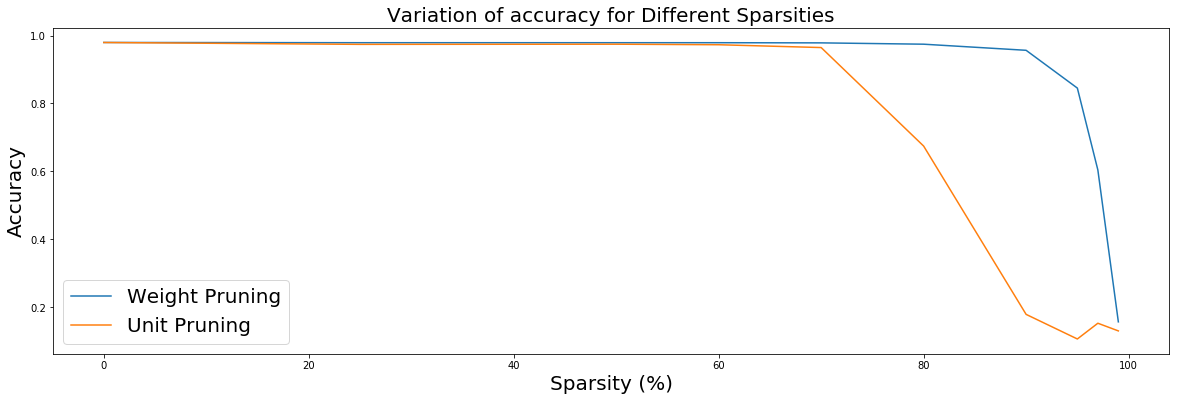

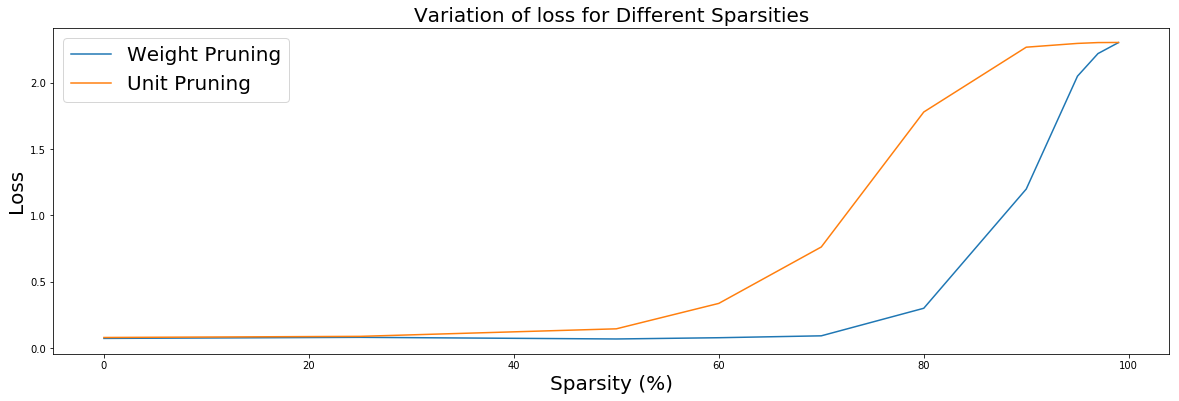

In [133]:
plt.figure(1, figsize = (20, 6))
plt.plot(sparsities, weighted_pruning_test_accuracy, label = "Weight Pruning")
plt.plot(sparsities, unit_pruning_test_accuracy, label = "Unit Pruning")
plt.xlabel('Sparsity (%)', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.title("Variation of accuracy for Different Sparsities", fontsize = 20)
plt.legend(fontsize = 20)

plt.figure(2, figsize = (20, 6))
plt.plot(sparsities, weighted_pruning_test_loss, label = "Weight Pruning")
plt.plot(sparsities, unit_pruning_test_loss, label = "Unit Pruning")
plt.xlabel('Sparsity (%)', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title("Variation of loss for Different Sparsities", fontsize = 20)
plt.legend(fontsize = 20)

plt.show()

1. For initial sparsity values, both weight and unit pruning are able to delete a good enough portion of the network while keeping the accuracy constant and loss minimum. So, pruning does indeed help us reduce networks without any general loss in performance.


2. However, as the sparsity values increase, we observe that weight pruning seems to perform better than unit pruning - the accuracy of the model remains constant under weight pruning even when we have deleted 80% of the weights in the layers. Hence, the predictive porwer of the model is retained and we have a smaller network with less number of parameters. On the other hand, unit pruning seems to be performing worse. After about 70% of pruning, the accuracy of the model decreases almost linearly and the loss increases at around the same sparsity as compared 80% for for weight pruning.


3. I think the main reason for such an observable difference between the two techniques is the way we handle the deletion of weights. Weighted pruning follows a more logical approach in the sense that it will look at all the weights in a layer and considering their magnitude, will delete some of them. On the other hand, unit pruning will tend to compare l2 norms and delete entire columns in the weight matrix - meaning it will delete entire neurons. **This is a very strict penalty and fails to produce good results because all neurons do contain some degree information in them and just deleting them entirely incurs a heavy cost on the network**.

In [134]:
network_trainer = NeuralNetworkPruner(num_epochs = 5, verbose = False)
network_trainer.fit(x_train, y_train)

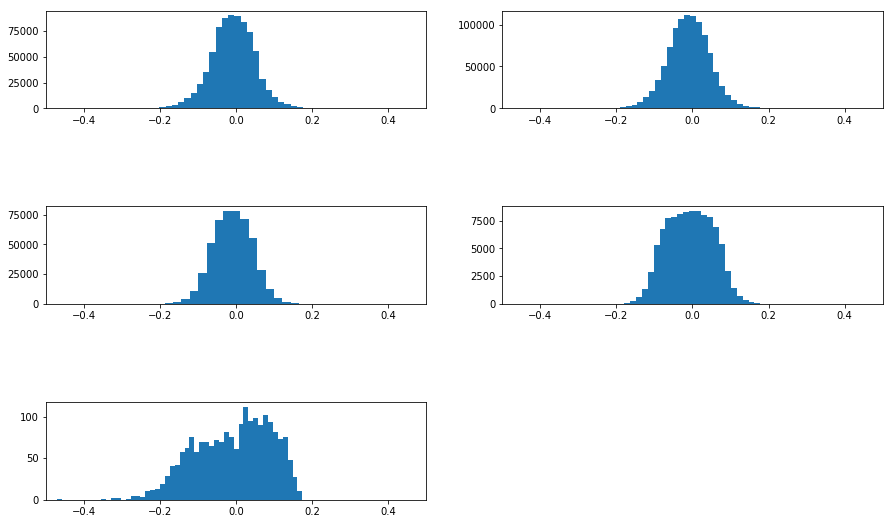

In [140]:
plt.figure(1, figsize = (15, 9))
plt.subplots_adjust(hspace = 1)
for index, weights in enumerate(network_trainer.model.trainable_weights):
    plt.subplot(3, 2, index + 1)
    plt.hist(weights.numpy().reshape(-1), bins = 50)
    plt.xlim(-0.5, 0.5);

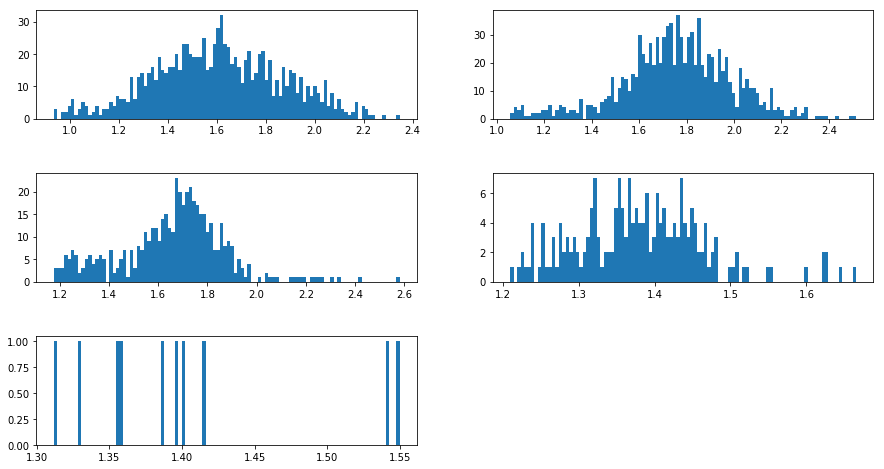

In [142]:
plt.figure(2, figsize = (15, 8))
plt.subplots_adjust(hspace = 0.5)
for index, weights in enumerate(network_trainer.model.trainable_weights):
    l2_norm_values = np.sqrt(np.sum(weights**2, axis = 0))
    plt.subplot(3, 2, index + 1)
    plt.hist(l2_norm_values, bins = 100);

5. We see that the weight values in each of the 5 layers are normally distributed with majority of the weights centered around and near 0. Thus, weight pruning will remove majority of small weights and this will not affect the performance of the network. On the other hand, the l2 norm values of the columns are more spread out away from 0 and hence, removing the neurons using l2 norm will indeed have some effect on the network performance. However, this difference in the 2 methods only starts to be noticeable when the amount of pruning becomes significant (>70%).


6. I think pruning works successfully because in a neural network, not all weights contribute a lot to the final output. In medium and large networks, most of the weights are so small that removing them will not have any impact on the result - this means that pruning can remove them successfully. But there is one catch - in my opinion, training a large network and then pruning them will incur a huge computational cost and cost time too. It may be better to simply train a smaller network from scratch rather than train it and then prune it. This hypothesis may be wrong for smaller tasks and in such cases pruning may infact result in a decent model in a tolerable time and computation.

## Bonus

I did not implement the network using tf.sparse but on reading the docs I did find that we can use **tf.sparse.matmul** to modify the neural network backprop. For this, I guess, we have to create a custom Neural Network class which will be able to add layers instead of the usual tensorflow API.